In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
os.listdir()

['.DS_Store',
 '4.2.0',
 'Agents.py',
 'agent_utils.py',
 'CentralDDQN.py',
 'DDQN.py',
 'DoubleDQN.py',
 'Environment.py',
 'job.py',
 'logs',
 'matching.py',
 'matthew.py',
 'Models',
 'notes.notes',
 'Old_DoubleDQN.py',
 'plant.py',
 'process_args.py',
 'Results',
 'run_batch_job.py',
 'run_batch_matthew.py',
 'run_batch_plant.py',
 'run_batch_simple.py',
 'run_job.bat',
 'run_job_discount.py',
 'run_warm_start_discount.py',
 'simple.py',
 'SplitDDQN.py',
 'test.py',
 'test_base_models.py',
 'test_beta_region.py',
 'test_job.py',
 'test_model.ipynb',
 'utils.py',
 'warm_start.py',
 '__pycache__']

In [2]:
from agent_utils import get_agent, take_env_step
from Agents import DDQNAgent, SplitDDQNAgent, MultiHeadDDQNAgent
from Environment import WarmStartEnvt
import copy
from utils import SI_reward, variance_penalty, get_fairness_from_su, EpsilonDecay, get_metrics_from_rewards, add_epi_metrics_to_logs, add_metric_to_logs


In [3]:
from process_args import process_args

args, train_args = process_args('WarmStartTest', load_default=True)

f:\anaconda3\envs\FEN\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
n_agents = 5
max_steps = 100

M = WarmStartEnvt(n_agents, reallocate=False, simple_obs=False, warm_start=0, past_discount=0.995,)
M_train = copy.deepcopy(M)
M_val = copy.deepcopy(M)
obs = M.get_obs()
num_features = len(obs[0][0])

In [5]:
agent = DDQNAgent(M_train, num_features, hidden_size=20, learning_rate=0.0003, replay_buffer_size=100000, GAMMA=0.98, learning_beta=0,)
agent.load_model("Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/0.0/1709862378/model_200.ckpt")
# agent.load_model("Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/1000.0/1709864451/model_200.ckpt")
# agent.load_model("Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/10000.0/1709863976/model_200.ckpt")
def load_agent(model_path, beta):
    agent = DDQNAgent(M_train, num_features, hidden_size=20, learning_rate=0.0003, replay_buffer_size=100000, GAMMA=0.98, learning_beta=beta,)
    agent.load_model(model_path)
    agent.learning_beta = beta
    return agent

Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/0.0/1709862378/model_200.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/0.0/1709862378/model_200.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/0.0/1709862378/model_200.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/0.0/1709862378/model_200.ckpt


In [6]:
def validate_and_plot(agent, M_val, max_steps, args, n_agents):
    agent.set_active_net(0)
    print("Final Validation")
    num_eps = 5
    M_val.external_trigger = True


    all_resource_rates =  []

    #Run validation episodes with the current policy
    val_metrics = {'system_utility':[], 'fairness':[], 'min_utility':[], 'objective':[],'variance':[]}
    for val_eps in range(num_eps):
        resource_rates = [[] for _ in range(n_agents)]
        M_val.reset()
        obs = M_val.get_obs()
        score = 0
        for steps in range(max_steps):
            util, obs = take_env_step(M_val, agent, obs, steps, 0, args, add_to_replay=False)
            score+=util

            for i in range(n_agents):
                resource_rates[i].append(M_val.resource_rate[i])

            if args.render:
                M_val.render()
                time.sleep(0.1)
                print(steps, val_eps)

        if score==0:
            print("Zero score")
            M_val.render()

        print(M_val.su)
        metrics = get_metrics_from_rewards(M_val.su, args.learning_beta, fair_rewards=M_val.resource_rate)
        for key, value in metrics.items():
            val_metrics[key].append(value)
        
        all_resource_rates.append(resource_rates)

    # Average the resource rates
    resource_rates = np.mean(all_resource_rates, axis=0)
    # plot the resource rates
    import matplotlib.pyplot as plt
    xs = range(len(resource_rates[0]))
    for i in range(n_agents):
        plt.plot(xs, resource_rates[i], label="Agent {}".format(i))
    plt.legend()

    mean_val_metrics = {}
    for key, value in val_metrics.items():
        mean_val_metrics[key] = np.mean(value)
    
    return mean_val_metrics

INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/0.0/1709862378/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/0.0/1709862378/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/0.0/1709862378/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/0.0/1709862378/best/best_model.ckpt
Final Validation
[100.   0.   0.   0.   0.]
[99.   0.   0.   0.   0.2]
[99.   0.   0.6  0.   0. ]
[99.   0.8  0.   0.   0. ]
[100.   0.   0.   0.   0.]


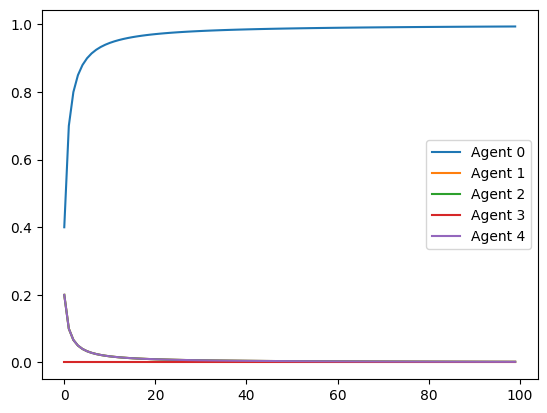

INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/1.0/1709862905/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/1.0/1709862905/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/1.0/1709862905/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/1.0/1709862905/best/best_model.ckpt
Final Validation
[99.   0.   0.   0.   0.2]
[99.   0.   0.   0.   0.2]
[99.   0.   0.   0.4  0. ]
[99.   0.   0.   0.4  0. ]
[99.   0.8  0.   0.   0. ]


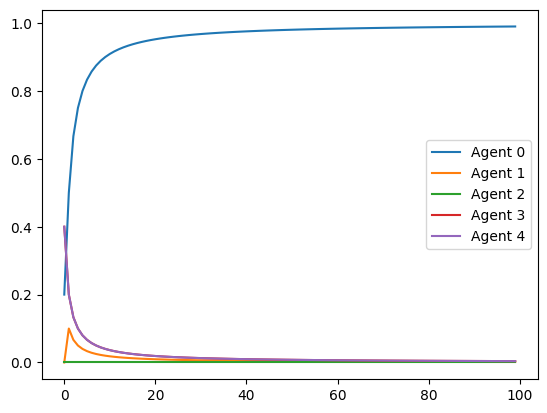

INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/10.0/1709863429/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/10.0/1709863429/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/10.0/1709863429/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/10.0/1709863429/best/best_model.ckpt
Final Validation
[98.   1.6  0.   0.   0. ]
[98.   1.6  0.   0.   0. ]
[98.   1.6  0.   0.   0. ]
[98.   1.6  0.   0.   0. ]
[98.   1.6  0.   0.   0. ]


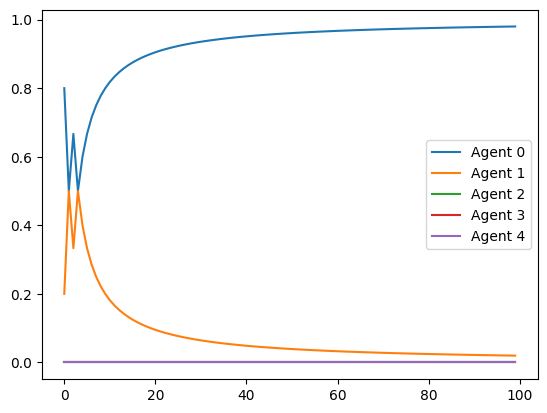

INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/100.0/1709863947/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/100.0/1709863947/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/100.0/1709863947/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/100.0/1709863947/best/best_model.ckpt
Final Validation
[80.  12.   1.8  0.4  0.2]
[80.  12.   1.8  0.4  0.2]
[80.  12.   1.8  0.4  0.2]
[80.  12.   1.8  0.4  0.2]
[80.  12.   1.8  0.4  0.2]


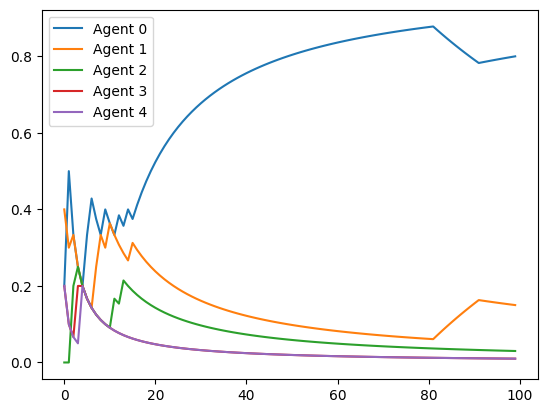

INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/1000.0/1709864451/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/1000.0/1709864451/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/1000.0/1709864451/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/1000.0/1709864451/best/best_model.ckpt
Final Validation
[31.  21.6 10.8  5.2  2.2]
[31.  21.6 10.8  5.2  2.2]
[31.  21.6 10.8  5.2  2.2]
[31.  21.6 10.8  5.2  2.2]
[31.  21.6 10.8  5.2  2.2]


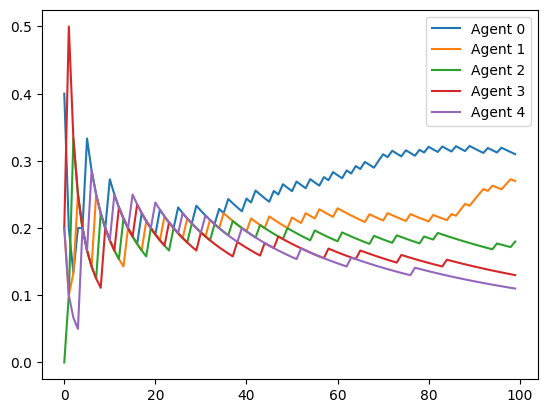

INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/10000.0/1709863976/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/10000.0/1709863976/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/10000.0/1709863976/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/10000.0/1709863976/best/best_model.ckpt
Final Validation
[20. 16. 12.  8.  4.]
[20. 16. 12.  8.  4.]
[20. 16. 12.  8.  4.]
[20. 16. 12.  8.  4.]
[20. 16. 12.  8.  4.]


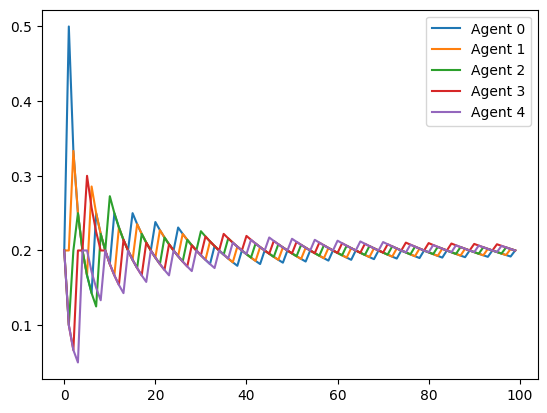

INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/2000.0/1709862923/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/2000.0/1709862923/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/2000.0/1709862923/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/2000.0/1709862923/best/best_model.ckpt
Final Validation
[27.  18.4 11.4  6.   3.2]
[27.  18.4 11.4  6.   3.2]
[27.  18.4 11.4  6.   3.2]
[27.  18.4 11.4  6.   3.2]
[27.  18.4 11.4  6.   3.2]


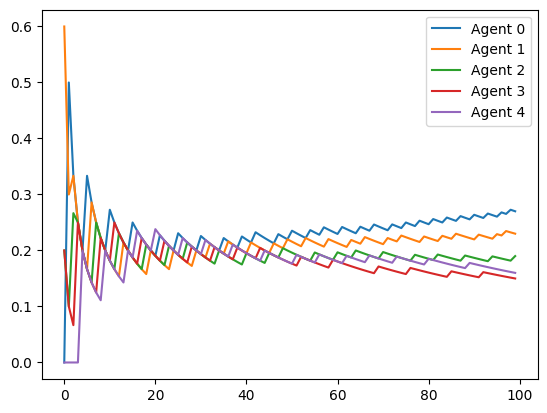

INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/500.0/1709862384/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/500.0/1709862384/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/500.0/1709862384/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/500.0/1709862384/best/best_model.ckpt
Final Validation
[39.  25.6 11.4  2.8  0.6]
[39.  25.6 11.4  2.8  0.6]
[39.  25.6 11.4  2.8  0.6]
[39.  25.6 11.4  2.8  0.6]
[39.  25.6 11.4  2.8  0.6]


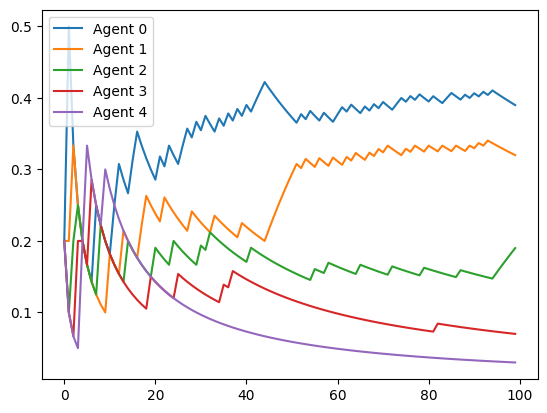

INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/5000.0/1709863449/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/5000.0/1709863449/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/5000.0/1709863449/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/5000.0/1709863449/best/best_model.ckpt
Final Validation
[22.  16.8 12.   7.6  3.6]
[22.  16.8 12.   7.6  3.6]
[22.  16.8 12.   7.6  3.6]
[22.  16.8 12.   7.6  3.6]
[22.  16.8 12.   7.6  3.6]


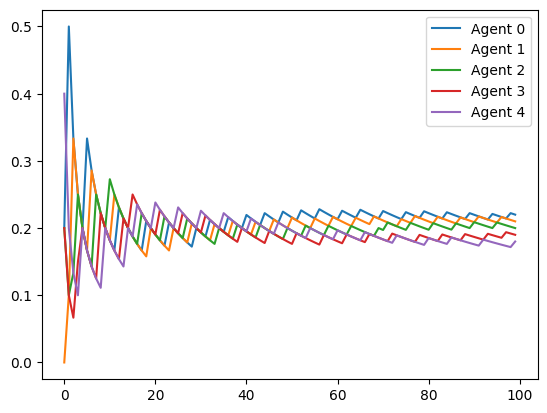

INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/50000.0/1709864477/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/50000.0/1709864477/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/50000.0/1709864477/best/best_model.ckpt
INFO:tensorflow:Restoring parameters from Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/50000.0/1709864477/best/best_model.ckpt
Final Validation
[20. 16. 12.  8.  4.]
[20. 16. 12.  8.  4.]
[20. 16. 12.  8.  4.]
[20. 16. 12.  8.  4.]
[20. 16. 12.  8.  4.]


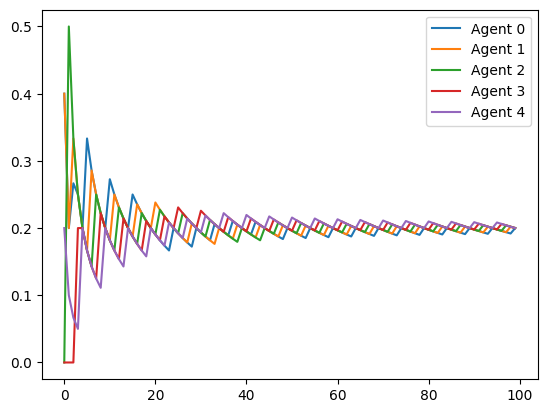

{0.0: {'system_utility': 99.72, 'fairness': -0.7877261369315345, 'min_utility': 0.0, 'objective': 99.72, 'variance': 0.15762400000000004}, 1.0: {'system_utility': 99.4, 'fairness': -0.779810094952524, 'min_utility': 0.0, 'objective': 99.4, 'variance': 0.15604000000000004}, 10.0: {'system_utility': 99.6, 'fairness': -0.7604197901049476, 'min_utility': 0.0, 'objective': 99.6, 'variance': 0.15216000000000002}, 100.0: {'system_utility': 94.4, 'fairness': -0.46336831584207905, 'min_utility': 0.01, 'objective': 94.4, 'variance': 0.09272000000000002}, 1000.0: {'system_utility': 70.80000000000001, 'fairness': -0.0303848075962019, 'min_utility': 0.11000000000000001, 'objective': 70.80000000000001, 'variance': 0.00608}, 10000.0: {'system_utility': 60.0, 'fairness': 0.0, 'min_utility': 0.2, 'objective': 60.0, 'variance': 0.0}, 2000.0: {'system_utility': 66.0, 'fairness': -0.009995002498750629, 'min_utility': 0.15, 'objective': 66.0, 'variance': 0.002000000000000001}, 500.0: {'system_utility': 79.

In [9]:
folder = "Models/WarmStart/warm5/past0.995/Simple/split_diff/Joint/"
betas = os.listdir(folder)
all_metrics = {}
for beta in betas:
    beta_val = float(beta)
    timestamp = os.listdir(folder+beta)[0]
    agent = load_agent(folder+beta+"/"+timestamp+"/best/best_model.ckpt", float(beta))
    metrics = validate_and_plot(agent, M_val, max_steps, args, n_agents)
    all_metrics[beta_val] = metrics
    plt.plot()
    plt.show()
print(all_metrics)

In [10]:
# Print the metrics prettily
for key, value in all_metrics.items():
    print(key, value)
import pandas as pd
df = pd.DataFrame(all_metrics)
df

0.0 {'system_utility': 99.72, 'fairness': -0.7877261369315345, 'min_utility': 0.0, 'objective': 99.72, 'variance': 0.15762400000000004}
1.0 {'system_utility': 99.4, 'fairness': -0.779810094952524, 'min_utility': 0.0, 'objective': 99.4, 'variance': 0.15604000000000004}
10.0 {'system_utility': 99.6, 'fairness': -0.7604197901049476, 'min_utility': 0.0, 'objective': 99.6, 'variance': 0.15216000000000002}
100.0 {'system_utility': 94.4, 'fairness': -0.46336831584207905, 'min_utility': 0.01, 'objective': 94.4, 'variance': 0.09272000000000002}
1000.0 {'system_utility': 70.80000000000001, 'fairness': -0.0303848075962019, 'min_utility': 0.11000000000000001, 'objective': 70.80000000000001, 'variance': 0.00608}
10000.0 {'system_utility': 60.0, 'fairness': 0.0, 'min_utility': 0.2, 'objective': 60.0, 'variance': 0.0}
2000.0 {'system_utility': 66.0, 'fairness': -0.009995002498750629, 'min_utility': 0.15, 'objective': 66.0, 'variance': 0.002000000000000001}
500.0 {'system_utility': 79.39999999999999, 

,0.0,1.0,10.0,100.0,1000.0,10000.0,2000.0,500.0,5000.0,50000.0
system_utility,99.720000,99.40000,99.60000,94.400000,70.800000,60.0,66.000000,79.400000,62.0000,60.0
fairness,-0.787726,-0.77981,-0.76042,-0.463368,-0.030385,0.0,-0.009995,-0.096352,-0.0010,0.0
min_utility,0.000000,0.00000,0.00000,0.010000,0.110000,0.2,0.150000,0.030000,0.1800,0.2
objective,99.720000,99.40000,99.60000,94.400000,70.800000,60.0,66.000000,79.400000,62.0000,60.0
variance,0.157624,0.15604,0.15216,0.092720,0.006080,0.0,0.002000,0.019280,0.0002,0.0


In [11]:
df_ = df.T
#sort rows by index
df_ = df_.sort_index()
print(df_)

         system_utility  fairness  min_utility  objective  variance
0.0               99.72 -0.787726         0.00      99.72  0.157624
1.0               99.40 -0.779810         0.00      99.40  0.156040
10.0              99.60 -0.760420         0.00      99.60  0.152160
100.0             94.40 -0.463368         0.01      94.40  0.092720
500.0             79.40 -0.096352         0.03      79.40  0.019280
1000.0            70.80 -0.030385         0.11      70.80  0.006080
2000.0            66.00 -0.009995         0.15      66.00  0.002000
5000.0            62.00 -0.001000         0.18      62.00  0.000200
10000.0           60.00  0.000000         0.20      60.00  0.000000
50000.0           60.00  0.000000         0.20      60.00  0.000000


In [12]:
#plot fairnes vs system_utility
import plotly.express as px
px.scatter(df_, x="system_utility", y="fairness", color=df_.index.astype(str))